In [1]:
import sys
sys.path.append("/Users/fsolleza/Documents/Projects/timeseries-data") # path to this repository
import py_ts_data
import time
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math
from kshape import _sbd as SBD
from auto_encoder import AutoEncoder, train_step

X_train, y_train, X_test, y_test, info = py_ts_data.load_data("TwoPatterns", variables_as_channels=True)
print("Dataset shape: Train: {}, Test: {}".format(X_train.shape, X_test.shape))
print(np.shape(y_train))

TS-Data path: /Users/jkm/Documents/MyDocuments/Brown_University/Spring_2021/cs2270/Analytics_Project/testCS227/data
Dataset shape: Train: (1000, 128, 1), Test: (4000, 128, 1)
(1000,)


In [2]:
def normalize(data):
    """
    Z-normalize data with shape (x, y)
    x = # of timeseries
    y = len of each timeseries
    
    s.t. each array in [., :, .] (i.e. each timeseries variable)
    is zero-mean and unit stddev
    """
    # sz, l = data.shape
    means = np.mean(data)
    stddev = np.std(data)
    return (data - means)/stddev

def flatten_and_normalize(tensor):
    # print(tf.reshape(tensor,[-1]))
    return normalize(tf.reshape(tensor,[-1]))
    
def augment_data(X_train, K = 1000, alpha = 0.1):
    # K is the target size, alpha is the fluctuated rate of fabricated data.
    repeat_times = K // len(X_train)
    new_x_data = None

    for _ in range(repeat_times):
        #for x_series, y_series in zip(X_train, y_train):
        for x_series in X_train:
            x_noise = 1 - 0.1 * (np.random.random(x_series.shape) - 0.5)

            new_x_series = np.reshape(x_series * x_noise, (1, len(x_series), 1))

            if new_x_data is None:
                new_x_data = new_x_series
            else:
                new_x_data = np.append(new_x_data, new_x_series, axis = 0)

    print("The original data shape is:", np.shape(X_train))
    X_train = np.append(X_train, new_x_data, axis = 0)
    print("The augmented data shape is:", np.shape(X_train))

    return X_train

X_train= augment_data(X_train)
num_train = len(X_train)
indices1 = np.random.choice(num_train, int(num_train * math.log2(num_train)))
indices2 = np.random.choice(num_train, int(num_train * math.log2(num_train)))

X = X_train[indices1]
Y = X_train[indices2]
print('X shape: ', X.shape)
print('Y shape: ', Y.shape)
# normalized_X = flatten_and_normalize(X)
# normalized_Y = flatten_and_normalize(Y)
normalized_X = normalize(X)
normalized_Y = normalize(Y)

normalized_X_2d = normalize(X).squeeze()
normalized_Y_2d = normalize(Y).squeeze()


print('normalized_X shape: ', normalized_X.shape)
print('normalized_Y shape: ', normalized_Y.shape)
distance = []
for x, y in zip(normalized_X_2d, normalized_Y_2d):
    distance.append(SBD(x, y))
distance = np.array(distance)
print('distance shape: ', distance.shape)
#distance = SBD(normalized_X, normalized_Y)

The original data shape is: (1000, 128, 1)
The augmented data shape is: (2000, 128, 1)
X shape:  (21931, 128, 1)
Y shape:  (21931, 128, 1)
normalized_X shape:  (21931, 128, 1)
normalized_Y shape:  (21931, 128, 1)
distance shape:  (21931,)


In [3]:
def min_max(data, feature_range=(0, 1)):
    """
    implements min-max scaler
    """
    min_v = feature_range[0]
    max_v = feature_range[1]
    max_vals = data.max(axis=1)[:, None, :]
    min_vals = data.min(axis=1)[:, None, :]
    X_std = (data - min_vals) / (max_vals - min_vals)
    return X_std * (max_v - min_v) + min_v

def normalize(data):
    """
    Z-normalize data with shape (x, y, z)
    x = # of timeseries
    y = len of each timeseries
    z = vars in each timeseres
    
    s.t. each array in [., :, .] (i.e. each timeseries variable)
    is zero-mean and unit stddev
    """
    sz, l, d = data.shape
    means = np.broadcast_to(np.mean(data, axis=1)[:, None, :], (sz, l, d))
    stddev = np.broadcast_to(np.std(data, axis=1)[:, None, :], (sz, l, d)) 
    return (data - means)/stddev


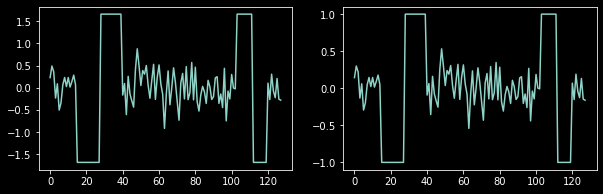

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(X_train[0])
X_train = min_max(X_train, feature_range=(-1, 1))
axs[1].plot(X_train[0])
X_test = min_max(X_test, feature_range=(-1, 1))
plt.show()

# Encode and Decode

In [5]:
kwargs = {
    "input_shape": (X_train.shape[1], X_train.shape[2]),
    "filters": [32, 64, 128],
    "kernel_sizes": [5, 5, 5],
    "code_size": 16,
}

ae = AutoEncoder(**kwargs)

# Training

In [6]:
EPOCHS = 8
# SHUFFLE_BUFFER = 100
# K = len(set(y_train))

# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER).batch(BATCH)

loss_history = []
t1 = time.time()
for epoch in range(EPOCHS):
    #total_loss = train_step(X_train, ae)
    total_loss = train_step(normalized_X, normalized_Y, distance, ae)

    # for i, (input, _) in enumerate(train_dataset):
    #     loss = train_step(input, ae)
    # total_loss += loss
    loss_history.append(total_loss)
    print("Epoch {}: {}".format(epoch, total_loss), end="\r")
    
print("The training time is:", time.time() - t1)
plt.plot(loss_history)

Epoch 0: 24.877151489257812Epoch 1: 20.196256637573242Epoch 2: 17.530839920043945Epoch 3: 15.444073677062988Epoch 4: 13.793935775756836Epoch 5: 12.585850715637207Epoch 6: 11.882684707641602Epoch 7: 11.544830322265625Epoch 8: 11.531904220581055Epoch 9: 11.613883972167969Epoch 10: 11.88470458984375

KeyboardInterrupt: 

# Test

## Evaluate reconstruction

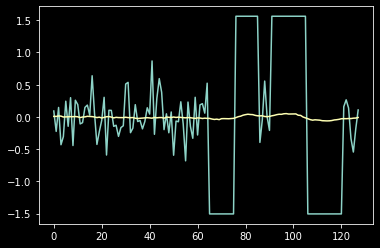

Mean L2 distance: 11.063879013061523


In [14]:
code_test = ae.encode(X_test)
decoded_test = ae.decode(code_test)

plt.plot(X_test[0])
plt.plot(decoded_test[0])
plt.show()

losses = []
for ground, predict in zip(X_test, decoded_test):
    losses.append(np.linalg.norm(ground - predict))
print("Mean L2 distance: {}".format(np.array(losses).mean()))

## Evaluate Similarity

In [15]:
from sklearn.neighbors import NearestNeighbors

def nn_dist(x, y):
    """
    Sample distance metric, here, using only Euclidean distance
    """
    x = x.reshape((50, 2))
    y = y.reshape((50, 2))
    return np.linalg.norm(x-y)

nn_x_test = X_test.reshape((-1, 100))
baseline_nn = NearestNeighbors(n_neighbors=10, metric=nn_dist).fit(nn_x_test)
code_nn = NearestNeighbors(n_neighbors=10).fit(code_test)

# For each item in the test data, find its 11 nearest neighbors in that dataset (the nn is itself)
baseline_11nn = baseline_nn.kneighbors(nn_x_test, 11, return_distance=False)
code_11nn     = code_nn.kneighbors(code_test, 11, return_distance=False)

# On average, how many common items are in the 10nn?
result = []
for b, c in zip(baseline_11nn, code_11nn):
    # remove the first nn (itself)
    b = set(b[1:])
    c = set(c[1:])
    result.append(len(b.intersection(c)))
np.array(result).mean()

0.01575